In [2]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
# get the data
features_df=pd.read_csv('data/features.csv')
store_df=pd.read_csv('data/stores.csv')
sales_df=pd.read_csv('data/train.csv')

# first look at how the data is stored

In [4]:
print(features_df.info(),store_df.info(),sales_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Typ

In [5]:
features_df["Date"] = pd.to_datetime(features_df["Date"])
sales_df["Date"] = pd.to_datetime(sales_df["Date"])
#we cant test\train on data later than 2012-10-26 so for this excersize it is useless
last_Date = sales_df.Date.max()
features_df = features_df[features_df["Date"]<=last_Date]

In [6]:
features_df.MarkDown5.value_counts(dropna=False)
#seems like theres no 0's in MarkDowns so we wont lose any information turning Nan into 0's but is it the right choice 

NaN        4140
1064.56       2
2743.18       2
492.36        1
755.80        1
           ... 
3154.77       1
1941.32       1
2862.32       1
1610.18       1
858.33        1
Name: MarkDown5, Length: 2294, dtype: int64

In [7]:
features_df["isNAn"] = features_df["MarkDown4"].isna()
#we will take MarkDown4 as a sample since the Data in other MarkDowns is similiar on other MarkDown columns

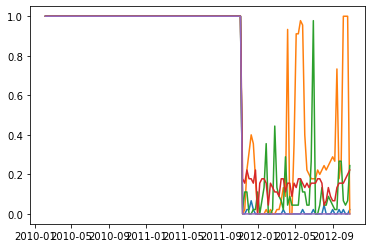

In [8]:
fig, ax = plt.subplots() 
for i in [1,2,3,4,5]:
    features_df["isNAn"] = features_df["MarkDown" + str(i)].isna()
    #fig, ax = plt.subplots()
    ax.plot(features_df.groupby("Date").isNAn.agg("mean"))

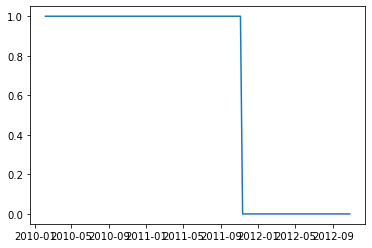

In [9]:
fig, ax = plt.subplots() 
ax.plot(features_df.groupby("Date").isNAn.agg("mean"))
#seems like they started tracking the markdowns only from a certain date thus 0 doesnt have a particular meaning 
#either take average markdown or not use markdowns(not ideal)
#if theres hope to get more markdown Data at the fututre to train on we would have used it but this time its better to use more data

In [10]:
#drop markdowns
markdowns = ["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5",]
features_df = features_df.drop (columns = markdowns)

**after doing immediate changes we will merge our data into one table**

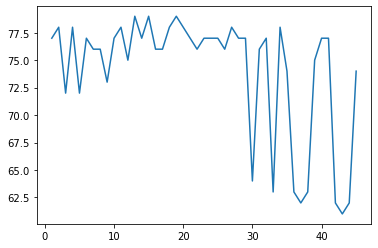

In [11]:
#first look at sales_df departments
fig, ax = plt.subplots() 
ax.plot(sales_df.groupby("Store").Dept.agg("nunique"))
#we can see not all stores have the same number or even the same departments
#we would want to predict the sales in each department

In [12]:
df = pd.merge(sales_df,features_df,how="outer",on=["Store","Date"])
df = pd.merge(df,store_df,how="outer",on=["Store"])
df=df.drop(columns=["isNAn"])

# first look at our data

In [13]:
df.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,211.096358,8.106,False,A,151315
5,1,6,2010-02-05,5749.03,False,42.31,2.572,211.096358,8.106,False,A,151315
6,1,7,2010-02-05,21084.08,False,42.31,2.572,211.096358,8.106,False,A,151315
7,1,8,2010-02-05,40129.01,False,42.31,2.572,211.096358,8.106,False,A,151315
8,1,9,2010-02-05,16930.99,False,42.31,2.572,211.096358,8.106,False,A,151315
9,1,10,2010-02-05,30721.50,False,42.31,2.572,211.096358,8.106,False,A,151315


In [14]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,227.232807,14.313000,219622.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday_x   421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   CPI           421570 non-null  float64       
 8   Unemployment  421570 non-null  float64       
 9   IsHoliday_y   421570 non-null  bool          
 10  Type          421570 non-null  object        
 11  Size          421570 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(5), int64(3), object(1)
memory usage: 36.2+ MB


In [16]:
df = df.drop(columns = ["IsHoliday_y"])
df.rename({"IsHoliday_x":"IsHoliday"},inplace=True)

In [17]:
df[df["Weekly_Sales"]<0].Weekly_Sales.describe()
#looks like the sales are not a typo mistake but actual losses

count    1285.000000
mean      -68.608218
std       231.664245
min     -4988.940000
25%       -41.000000
50%       -13.200000
75%        -4.940000
max        -0.020000
Name: Weekly_Sales, dtype: float64

In [18]:
multi_index_df=df.set_index(["Store","Dept","Date"])

In [27]:
multi_index_df.groupby(level=[0,1]).shift(1)
#not in final product, just an example of how to work with multi index

Weekly_Sales IsHoliday_x  Temperature  Fuel_Price  \
Store Dept Date                                                            
1     1    2010-02-05           NaN         NaN          NaN         NaN   
      2    2010-02-05           NaN         NaN          NaN         NaN   
      3    2010-02-05           NaN         NaN          NaN         NaN   
      4    2010-02-05           NaN         NaN          NaN         NaN   
      5    2010-02-05           NaN         NaN          NaN         NaN   
...                             ...         ...          ...         ...   
45    93   2012-10-26       2270.50       False        56.47       3.969   
      94   2012-10-26       4655.65       False        56.47       3.969   
      95   2012-10-26      48434.97       False        56.47       3.969   
      97   2012-10-26       5575.90       False        56.47       3.969   
      98   2012-10-26        760.01       False        56.47       3.969   

                              CPI  Unemployment Type      Size  
Store Dept Date                                                 
1     1    2010-02-05         NaN           NaN  NaN       NaN  
      2    2010-02-05         NaN           NaN  NaN       NaN  
      3    2010-02-05         NaN           NaN  NaN       NaN  
      4    2010-02-05         NaN           NaN  NaN       NaN  
      5    2010-02-05         NaN           NaN  NaN       NaN  
...                           ...           ...  ...       ...  
45    93   2012-10-26  192.330854         8.667    B  118221.0  
      94   2012-10-26  192.330854         8.667    B  118221.0  
      95   2012-10-26  192.330854         8.667    B  118221.0  
      97   2012-10-26  192.330854         8.667    B  118221.0  
      98   2012-10-26  192.330854         8.667    B  118221.0  

[421570 rows x 8 columns]

In [30]:
multi_index_df[""]=multi_index_df.groupby(level=[0,1])["Weekly_Sales"].shift(1)

<AxesSubplot:xlabel='last_Week_Sales'>

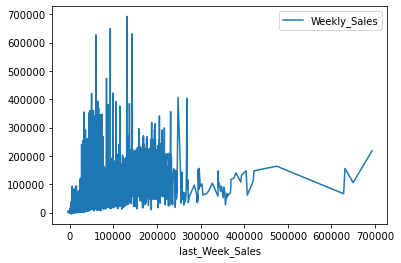